In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
kb = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

from misloc_mispol_package.parameterize import displaced_osc_model as dom


In [12]:
## This needs to be in a seperate cell from the imports
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 300,  # to adjust notebook inline plot size
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
#     'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4, 3], # 4 x 3
    'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)


In [3]:
path_to_mol_data = (
    "/Users/chair/Documents/Academia/SuperRes/Biteen_colab/"+
    "Mispolarization/python/gitted/spectral_fitting/")

def norm_spec(spec):
    return spec/spec.max()

def nm_to_ev_correct(spec):
    return spec/(1240/thermo_fisher_dye_data.T[0])**5.

In [4]:
emily_data = np.loadtxt(
    os.path.join(path_to_mol_data, 'CN.csv'), 
#     skiprows=0, 
    delimiter=','
    )

In [5]:
def model_from_params(params, num_modes):
    return dom.mol_fluo_model(
        num_vib_modes=num_modes,
        hbar_omega_eg_0=float(params[0]),
        script_d=params[2+2*num_modes: 2+3*num_modes],
        hbar_omega_0=params[2: 2+1*num_modes],
        hbar_gamma=params[2+1*num_modes: 2+2*num_modes],
        T=params[1],)

def muk_mol_fit_fun(params, *args):
    """ Try naive fit function with fixed integration differential size
        and bound.

        Params: (list of fit parameters) Should be list of 
            2 + (3*num_modes) containing the following model parameters;
            ~~~~~~~~~~~~~~~~
            [0] hbar_omega_eg_0: the difference in zero point energy of 
                the vibrational oscillators between the two electronic
                states (eV).
                
            [1] T: temperature 
            
            [2:2+num_modes] hbar_omega_0: vibrational ressonance energy 
                in eV.
                
            [2+num_modes:2+2*num_modes] hbar_gamma: damping rate from 
                solvent or etc.
                
            [2+2*num_modes: 2+3*num_modes]script_d: unitless 
                displacement of the vibronic potential surface between
                electronic states.

        Args: (list of x axis and data)
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            hbar_omega:
            data:
            num_modes:
        """
#     print(f'params:{params}, args:{args}')
    ## Define params and args with meaningful names
#     hbar_omega_eg_0, T, hbar_omega_0, hbar_gamma, script_d, = params
    ## params are ordered by 
    hbar_omegas, data, num_modes, t_bound, t_points, norm = args

    model_instance = model_from_params(params, num_modes)
    
    model = model_instance.emission_lineshape(
        hbar_omegas/hbar,
        t_bound=t_bound,
        t_points=t_points,)

    ## Normalize model and data
    model = model / np.max(model)
    data = data / np.max(data)

    return model - data

In [6]:
# hbar_omega_eg_0=2.55,
#     script_d=[1.9, .6],
#     hbar_omega_0=[0.15, .1],
#     hbar_gamma=[.01, .01],
#     T=300

ini_hbar_omega_eg_0 = 2.64
ini_script_d = [1.6, 1.3]
ini_hbar_omega_0 = [0.15, .06]
ini_hbar_gamma = [.01, .03]
ini_T = 300

bounds_hbar_omega_eg_0 = [0, np.inf]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [[0.001, 0], [np.inf, np.inf]]
bounds_T = [299, 301]


fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_T,
    *ini_hbar_omega_0,
    *ini_hbar_gamma,
    *ini_script_d,
    ])


hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = True

fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_T
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_hbar_gamma
bounds[:, 2+2*num_modes_arg:2+3*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds
    )

Text(0, 0.5, 'Normalized Emission Probability')

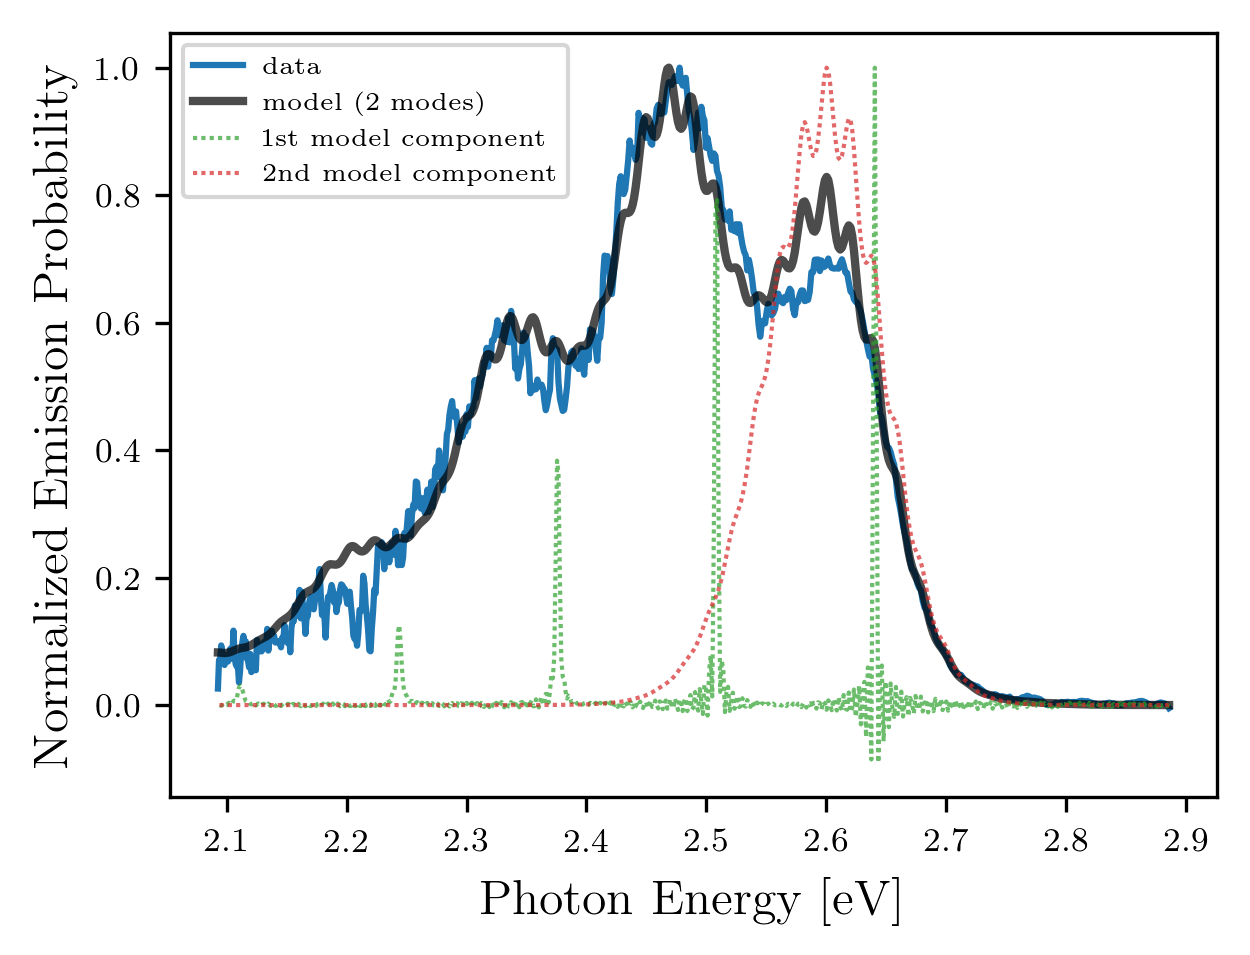

In [13]:
model_fit_inst = model_from_params(model_fit['x'], 2)

model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

In [9]:
model_fit['x']

array([2.64032806e+00, 2.99000000e+02, 1.32176450e-01, 1.99605349e-02,
       1.00000000e-03, 1.33760493e-03, 1.54512017e+00, 2.09882725e+00])

hbar_omega_eg_0=2.64032806e+00,
T=2.99000000e+02,
hbar_omega_0=[1.32176450e-01, 1.99605349e-02],
hbar_gamma=[1.00000000e-03, 1.33760493e-03],
script_d=[1.54512017e+00, 2.09882725e+00],

In [11]:
(np.array([1.54512017e+00, 2.09882725e+00])**2)/2

array([1.19369817, 2.20253791])

Try larger min on gamma

In [ ]:
v

In [14]:
# hbar_omega_eg_0=2.55,
#     script_d=[1.9, .6],
#     hbar_omega_0=[0.15, .1],
#     hbar_gamma=[.01, .01],
#     T=300

ini_hbar_omega_eg_0 = 2.64
ini_script_d = [1.6, 1.3]
ini_hbar_omega_0 = [0.15, .06]
ini_hbar_gamma = [.01, .03]
ini_T = 300

bounds_hbar_omega_eg_0 = [0, np.inf]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [[0.01, 0], [np.inf, np.inf]]
bounds_T = [299, 301]


fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_T,
    *ini_hbar_omega_0,
    *ini_hbar_gamma,
    *ini_script_d,
    ])


hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = True

fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_T
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_hbar_gamma
bounds[:, 2+2*num_modes_arg:2+3*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds
    )

Text(0, 0.5, 'Normalized Emission Probability')

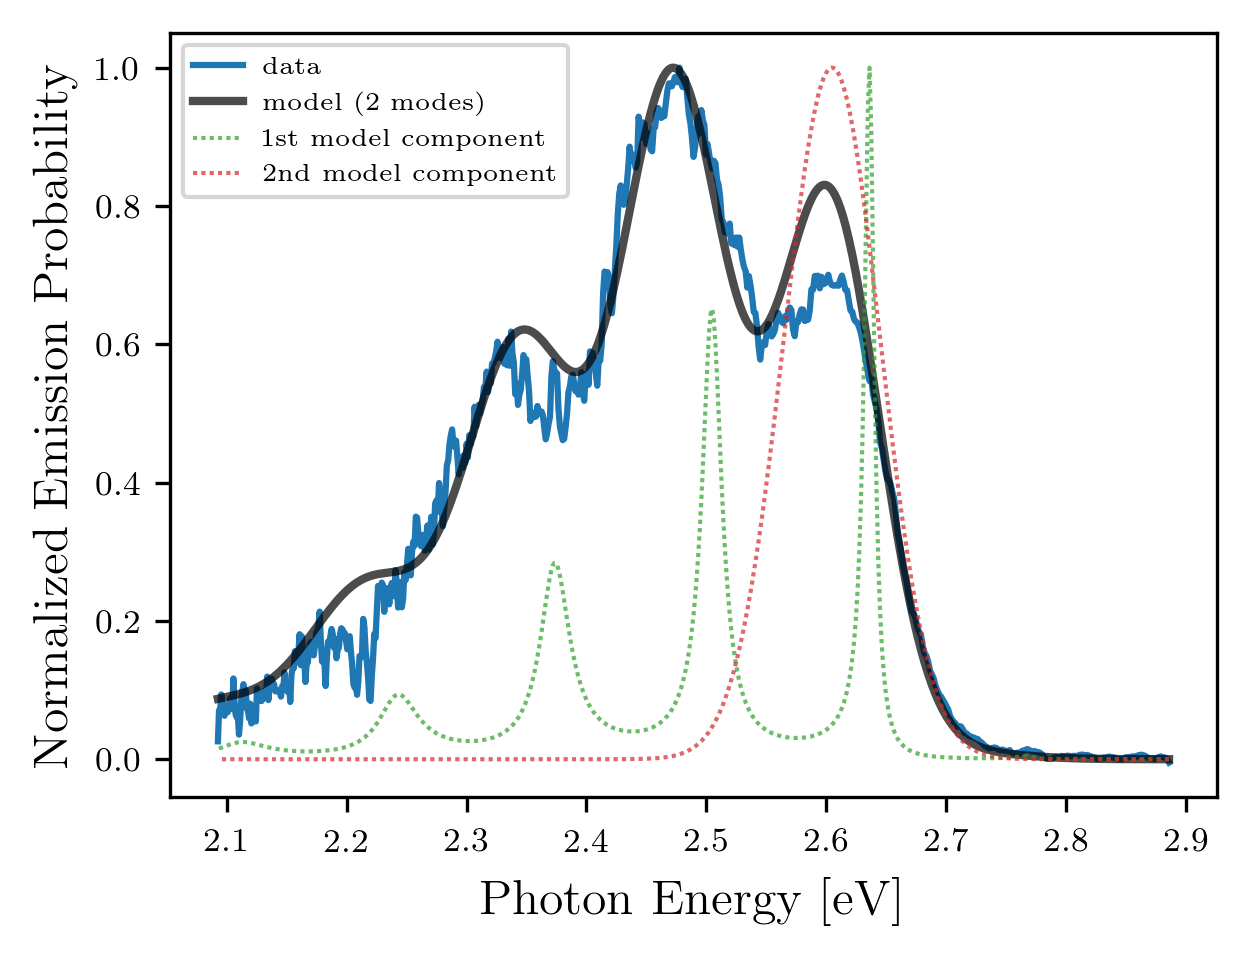

In [15]:
model_fit_inst = model_from_params(model_fit['x'], 2)

model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

In [16]:
# hbar_omega_eg_0=2.55,
#     script_d=[1.9, .6],
#     hbar_omega_0=[0.15, .1],
#     hbar_gamma=[.01, .01],
#     T=300

ini_hbar_omega_eg_0 = 2.64
ini_script_d = [1.6, 1.3]
ini_hbar_omega_0 = [0.15, .06]
ini_hbar_gamma = [.01, .03]
ini_T = 300

bounds_hbar_omega_eg_0 = [0, np.inf]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [[0.005, 0], [np.inf, np.inf]]
bounds_T = [299, 301]


fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_T,
    *ini_hbar_omega_0,
    *ini_hbar_gamma,
    *ini_script_d,
    ])


hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = True

fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_T
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_hbar_gamma
bounds[:, 2+2*num_modes_arg:2+3*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds
    )

Text(0, 0.5, 'Normalized Emission Probability')

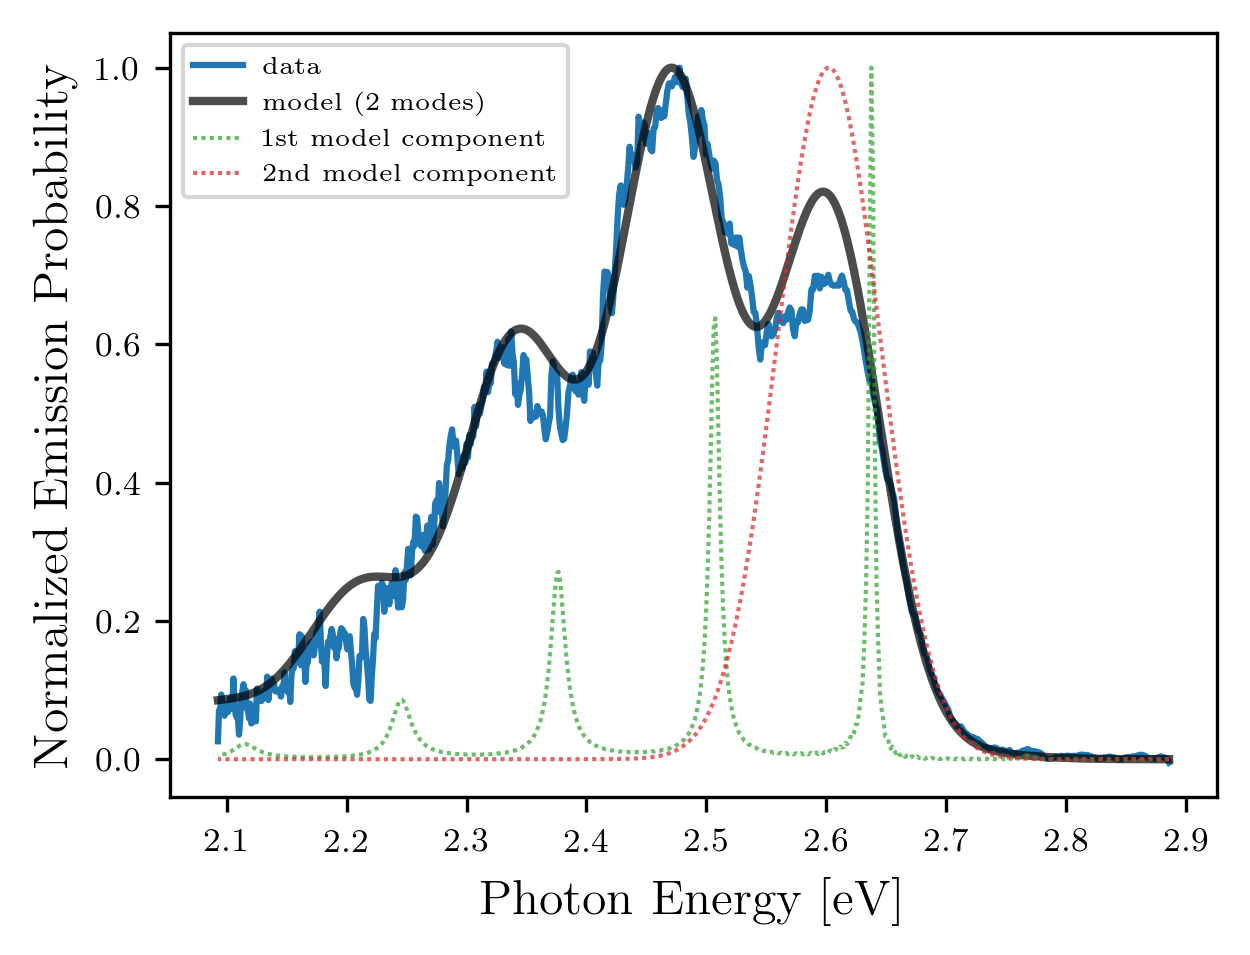

In [17]:
model_fit_inst = model_from_params(model_fit['x'], 2)

model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

In [18]:
model_fit['x']

array([2.63765796e+00, 3.00517498e+02, 1.30774831e-01, 1.09047951e-02,
       5.00000000e-03, 7.76283956e-01, 1.58083799e+00, 2.56037005e+00])